<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 🚙 💻 05 - Wheel encoder based odometry

"Odometry" is the problem of "measuring the path", or evolution of the pose in time, of the robot. 

We can solve the odometry problem by using the measurements from wheel encoders. We use the dead-reckoning model to estimate the evolution of the pose in time through an iterative procedure, such that:

<p style="text-align:center;"><img src="../images/odometry/odometry-1.png" width="500" alt="odometry-1"></p>   

$$ x_{k+1} = x_k + \Delta x_k $$
$$ y_{k+1} = y_k + \Delta y_k $$
$$ \theta_{k+1} = \theta_k + \Delta \theta_k $$

Where initial conditions ($x_0$, $y_0$, $\theta_0$) are assumed to be known. The increments can be calculated by:

1. Determining the rotation of each wheel through the wheel encoder mesurements

$$\Delta \phi_k = N_k \cdot \alpha$$

where $N_k$ is the number of pulses, or "ticks", measured from the encoders in the $k-th$ time interval, $\alpha = \frac{2 \pi}{N_{tot}}$ is the rotation per tick, and $N_{tot}$ the total number of ticks per revolution ($N_{tot} = 135$ for the wheel encoders we will be using). This relation is evaluated for each wheel, yielding $\Delta \phi_{l,k}$ and $\Delta \phi_{r,k}$ for the left and right wheels respectively.

2. Deriving the total distance travelled by each wheel

<p style="text-align:center;"><img src="../images/odometry/odometry-d.png" width="300" alt="odometry-d"></p> 

Assuming the wheel radii are the same (equal to $R$) for both wheels, the distance travelled by each wheel is given by:

$$ d_{l/r, k} = R \cdot \Delta \phi_{l/r,k}$$

3. Find the rotation and distance travelled by the robot (frame)

<p style="text-align:center;"><img src="../images/odometry/odometry-2.png" width="300" alt="odometry-2"></p>    

Under the assumption of no slipping of the robot wheel, we can derive the distance travelled by the origin of the robot frame (point $A$) and the rotation of the robot $\Delta \theta$:

$$ d_{A, k} = \frac{d_{r,k} + d_{l,k}}{2} $$
$$ \Delta \theta_{k} = \frac{d_{r,k} - d_{l,k}}{2L}$$

4. Express the robot motion in the world reference frame

<p style="text-align:center;"><img src="../images/odometry/odometry-3.png" width="300" alt="odometry-3"></p>

Finally, we can express the estimated motion in the world reference frame and find:

$$ \Delta x_k = d_{A, k} \cos\theta_k $$
$$ \Delta y_k = d_{A, k} \sin\theta_k $$

# 🚙 💻 Let's get started!

In this activity you will write a function that produces an estimate of the pose of the Duckiebot, given mesurements from the wheel encoders and an initial position:

In [ ]:
x0 = y0 = 0 # meters
theta0 = 0 # radians

## 1. Determining the rotation of each wheel through the wheel encoder mesurements

We've seen how to read wheel encoder data. Let's now use it to measure how much each wheel has rotated. 

### Wheel encoder calibration factor

Remember that there are 135 ticks per revolution on the wheel encoders we are using. 

In [5]:
import numpy as np 
 
N_tot = 135 # total number of ticks per revolution
alpha = 2 * np.pi / N_tot # wheel rotation per tick in radians

print(f"The angular resolution of our encoders is: {np.rad2deg(alpha)} degrees")

The angular resolution of our encoders is: 2.6666666666666665 degrees


Solution: The angular resolution of our encoders is: 2.6666666666666665 degrees

Let's suppose that at the current update the encoders have produced the following measurements:

In [6]:
# Feel free to play with the numbers to get an idea of the expected outcome

ticks_left = 1
prev_tick_left = 0

ticks_right = 0
prev_tick_right = 0

How much did each wheel rotate? (Express your answer in degrees - machines always use radians, humans make sense of degrees better. Mixing these up is a very very common source of error!).

In [7]:
# How much would the wheels rotate with the above tick measurements? 

delta_ticks_left = ticks_left-prev_tick_left # delta ticks of left wheel in arbitrary dt
delta_ticks_right = ticks_right-prev_tick_right # delta ticks of right wheel in same dt

rotation_wheel_left = alpha * delta_ticks_left # total rotation of left wheel in dt
rotation_wheel_right = alpha * delta_ticks_right # total rotation of right wheel in dt

print(f"The left wheel rotated: {np.rad2deg(rotation_wheel_left)} degrees")
print(f"The right wheel rotated: {np.rad2deg(rotation_wheel_right)} degrees")

The left wheel rotated: 2.6666666666666665 degrees
The right wheel rotated: 0.0 degrees


Solution: 

The left wheel rotated: 5.333333333333333 degrees

The right wheel rotated: 8.0 degrees

## 2. 🚙 💻 Evaluate distance travelled by each wheel

Now let's calculate the distance travelled by each wheel. It depends on the wheel radii. We need to determine it! We could use advanced odometry calibration procedures, but let's take it a step at the time. 

If you have a robot, take a ruler and measure your wheel radii (let's assume they are the same):

In [1]:
# What is the radius of your wheels? 
R = 0.033 # insert value measured by ruler, in *meters*

Note: the default value used in simulation and on the robot is $R = 0.0318 \text{m}$.

In [9]:
# What is the distance travelled by each wheel?

d_left = R * rotation_wheel_left 
d_right = R * rotation_wheel_right

print(f"The left wheel travelled: {d_left} meters")
print(f"The right wheel rotated: {d_right} meters")

The left wheel travelled: 0.00153588974175501 meters
The right wheel rotated: 0.0 meters


### 🚙 Save your new value of `R`

If you have a Duckiebot, let's make sure it remembers its new wheel radius! You should already know how to do this from [wheel calibration tutorial](../03-Wheel-Calibration/wheels_calibration.ipynb). 

Else, you can follow this slightly more straightforward approach. Power you Duckiebot on, make sure it is connected to the network and you can ping it, then open a terminal **on your computer** and type:

    dts start_gui_tools ROBOTNAME
    
    rosparam set /ROBOTNAME/kinematics_node/radius R-value
    
where `R-value` is the value of the wheel radius you measured (expressed in meters). You can then save it with: 

    rosservice call /ROBOTNAME/kinematics_node/save_calibration
    
and finally verify that it has been saved by opening the `ROBOTNAME.yaml` file in your Dashboard > File Manager > Calibrations > Kinematics page.

You can keep the terminal you just used open, so we can save the baseline measurement too. Let's keep going!

## 3. 🚙 💻 Find the rotation and distance travelled by the robot

If you have previoulsy set your robot's gain so that the wheels do not slip, the travelled distance of point $A$ (origin of the robot frame) will be given by the average of the distances travelled by the wheels:

In [10]:
# How much has the robot travelled? 

d_A = (d_left + d_right)/2

print(f"The robot has travelled: {d_A} meters")

The robot has travelled: 0.000767944870877505 meters


To calculate the rotation of the robot we need to measure the baseline - or the distance from the ceter of the two wheels. 

<p style="text-align:center;"><img src="../images/odometry/odometry-baseline.png" width="300" alt="odometry-baseline"></p>  

If you have a robot, take a ruler and measure it! 

In [11]:
# What is the baseline length of your robot? 

baseline_wheel2wheel = 0.108 #  Distance between the center of the two wheels, expressed in meters 

In [12]:
Delta_Theta = (d_right-d_left)/baseline_wheel2wheel # double check

### 🚙 Save your new value of `baseline`

Let's make sure it remembers its new wheel baseline! You should already know how to do this from [wheel calibration tutorial](../03-Wheel-Calibration/wheels_calibration.ipynb). 

Else, you can follow this slightly more straightforward approach. Power you Duckiebot on, make sure it is connected to the network and you can ping it, then open a terminal **on your computer** and type:

    dts start_gui_tools ROBOTNAME
    
    rosparam set /ROBOTNAME/kinematics_node/baseline baseline-value
    
where `baseline-value` is the value of `baseline_wheel2wheel` you just measured (expressed in meters). You can then save it with: 

    rosservice call /ROBOTNAME/kinematics_node/save_calibration
    
and finally verify that it has been saved by opening the `ROBOTNAME.yaml` file in your Dashboard > File Manager > Calibrations > Kinematics page.

# 💻 🚙 Write the odometry function

We've been practicing so far. 

Now it's time to write the functions that will actually be running on the robot (in simulation or on the physical one). 

You will write two functions:

1. A function that calculates the rotation of a wheel given a message from the wheel encoders and the previous number of ticks measured;

2. The actual odometry function, that will receive as inputs the kinematic model parameters, the pose estimate at the previous iteration, and the rotation of each wheel. The initial position is assumed to be $q_0 = [0,0,0]^ T

## Calculating the rotation of each wheel

In [8]:
# The function written in this cell will actually be ran on your robot (sim or real). 
# Put together the steps above and write your odometry function! 

# DO NOT CHANGE THE NAME OF THIS FUNCTION OR THINGS WILL BREAK

def DeltaPhi(encoder_msg, prev_ticks):
    """
        Args:
            encoder_msg: ROS encoder message (ENUM)
            prev_ticks: Previous tick count from the encoders (int)
        Return:
            rotation_wheel: Rotation of the wheel in radians (double)
            ticks: current number of ticks (int)
    """
    ticks = encoder_msg.data

    delta_ticks = ticks-prev_ticks
    
    # for debugging
    print(f"        DELTA TICKS  {encoder_msg.header.frame_id}")
    print(delta_ticks)

    N_tot = encoder_msg.resolution #total number of ticks per wheel revolution

    alpha = 2*np.pi/N_tot # rotation per tick in radians 

    delta_phi = alpha*delta_ticks # in radians
    
    return delta_phi, ticks

## Estimating the odometry

In [1]:
# The function written in this cell will actually be ran on your robot (sim or real). 
# Put together the steps above and write your odometry function! 

import numpy as np 

# DO NOT CHANGE THE NAME OF THIS FUNCTION OR THINGS WILL BREAK

def poseEstimation( R, # radius of wheel (assumed identical) - this is fixed in simulation, and will be imported from your saved calibration for the physical robot
                    baseline_wheel2wheel, # distance from wheel to wheel; 2L of the theory
                    x_prev, # previous x estimate - assume given
                    y_prev, # previous y estimate - assume given
                    theta_prev, # previous orientation estimate - assume given
                    delta_phi_left, # left wheel rotation (rad)
                    delta_phi_right): # right wheel rotation (rad)
    
    """
        Calculate the current Duckiebot pose using dead reckoning approach.

        Returns x,y,theta current estimates:
            x_curr, y_curr, theta_curr (:double: values)
    """
    
    r = -0.0036861506055818716 # make different than zero if you have reason to believe the wheels are of different sizes.
    
    R_left = R * (1-r)
    R_right = R * (1+r)
    
    d_left = R_left * delta_phi_left 
    d_right = R_right * delta_phi_right
    
    d_A = (d_left + d_right)/2
    
    Dtheta = (d_right - d_left)/baseline_wheel2wheel
    Dx = d_A * np.cos(theta_prev)
    Dy = d_A * np.sin(theta_prev)
    
    x_curr = x_prev + Dx
    y_curr = y_prev + Dy
    theta_curr = theta_prev + Dtheta

    return x_curr, y_curr, theta_curr

### Test the poseEstimation function

Unit tests are useful to check if a piece of code you write does its intended job. Although the interaction of different functions might yield surprises even when each function produces the expected outcome, it is good pratice to test the in isolation before prime time! These are called "unit tests", and:

> If it ain't tested, it's broken. 
>
> --Roboticists, level 9

Let's see if the function you wrote above passes the following test!

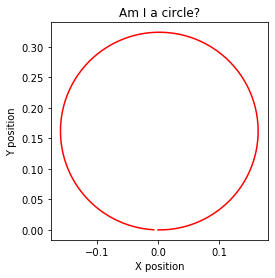

In [2]:
import os, sys
sys.path.append('../')
from unit_test import UnitTestOdometry

# This function has hardcoded values (bad practice!) to test the poseEstimate function above. 
# The test will be successful if you get a circle. Anything short of a circle.. probably best to go back and check. 

R = 0.033 # for the sake of this unit test, keep these values, regardless of what you have measured.
baseline_wheel2wheel = 0.108

UnitTestOdometry(R, baseline_wheel2wheel, poseEstimation)


A successful test will yield something similar to this result: 

<p style="text-align:center;">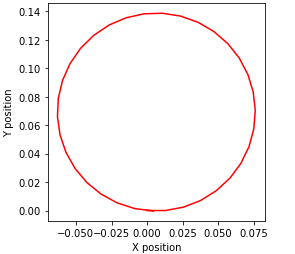</p>  


# 💻 🚙 Run the Activity

Let's now see how the odometry is working in pratice. 

💻 🚙 The first objective of this activity is to run the scripts you just wrote on a simulated and real robot, and see how they perform. 

💡 The second objective is reflecting on the outcome and trying to have the theory agree with your observations. 

## 💻 Running the odometry in simulation

1. Open a terminal on your computer, and type 

       dts exercises build
       
2. Wait for the build to finish, then type:

       dts exercises test --sim
       
3. Open VNC on you browser. 

4. Double-click on the "Odometry" icon on the Desktop

<p style="text-align:center;">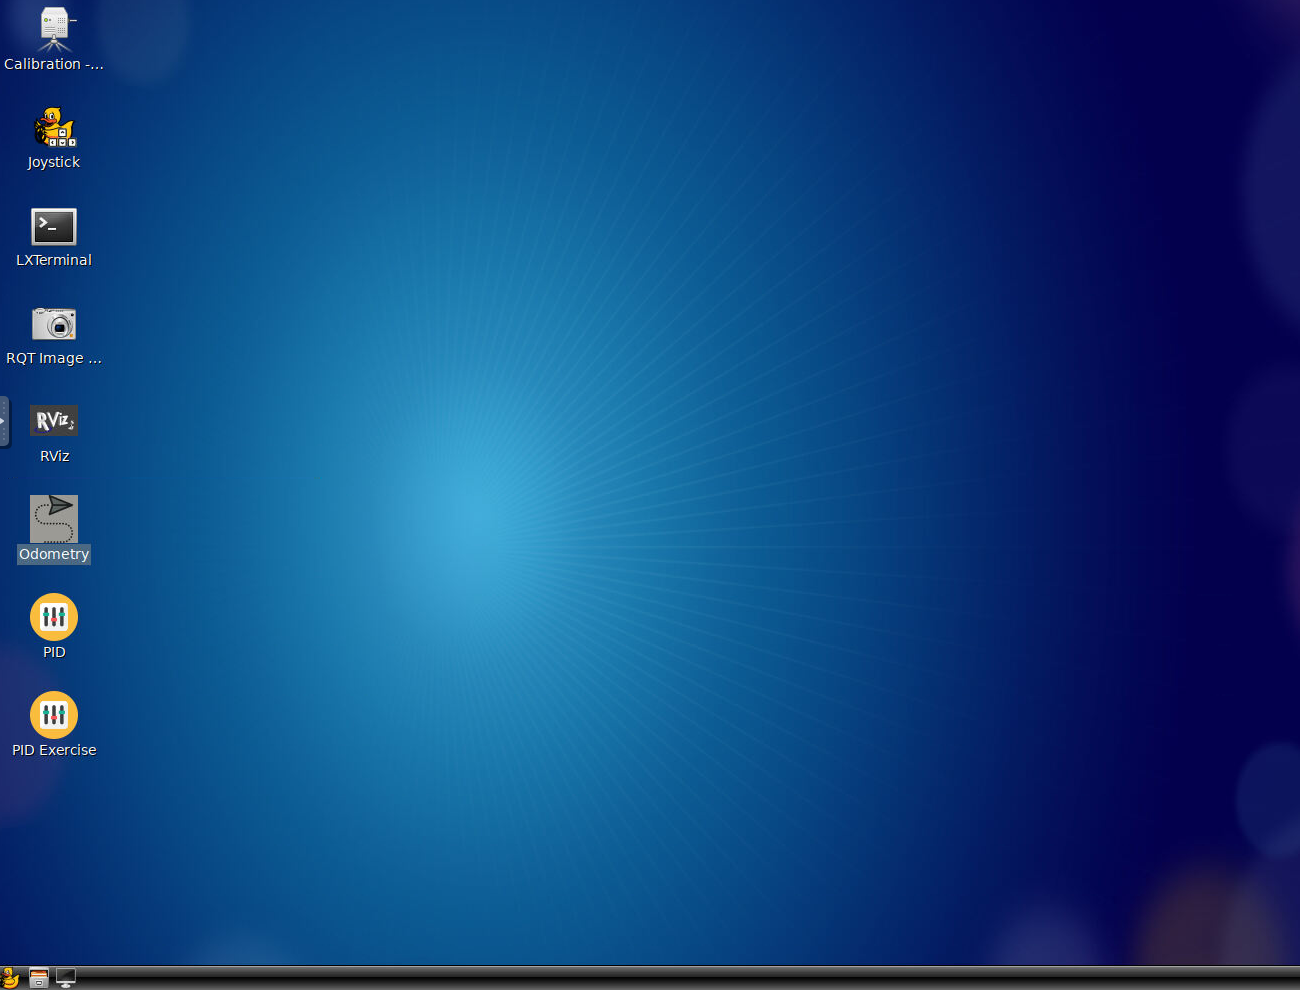</p>  

You will see three things opening: 

- a terminal
- a pre-configured RVIZ window
- a virtual joystick

<p style="text-align:center;">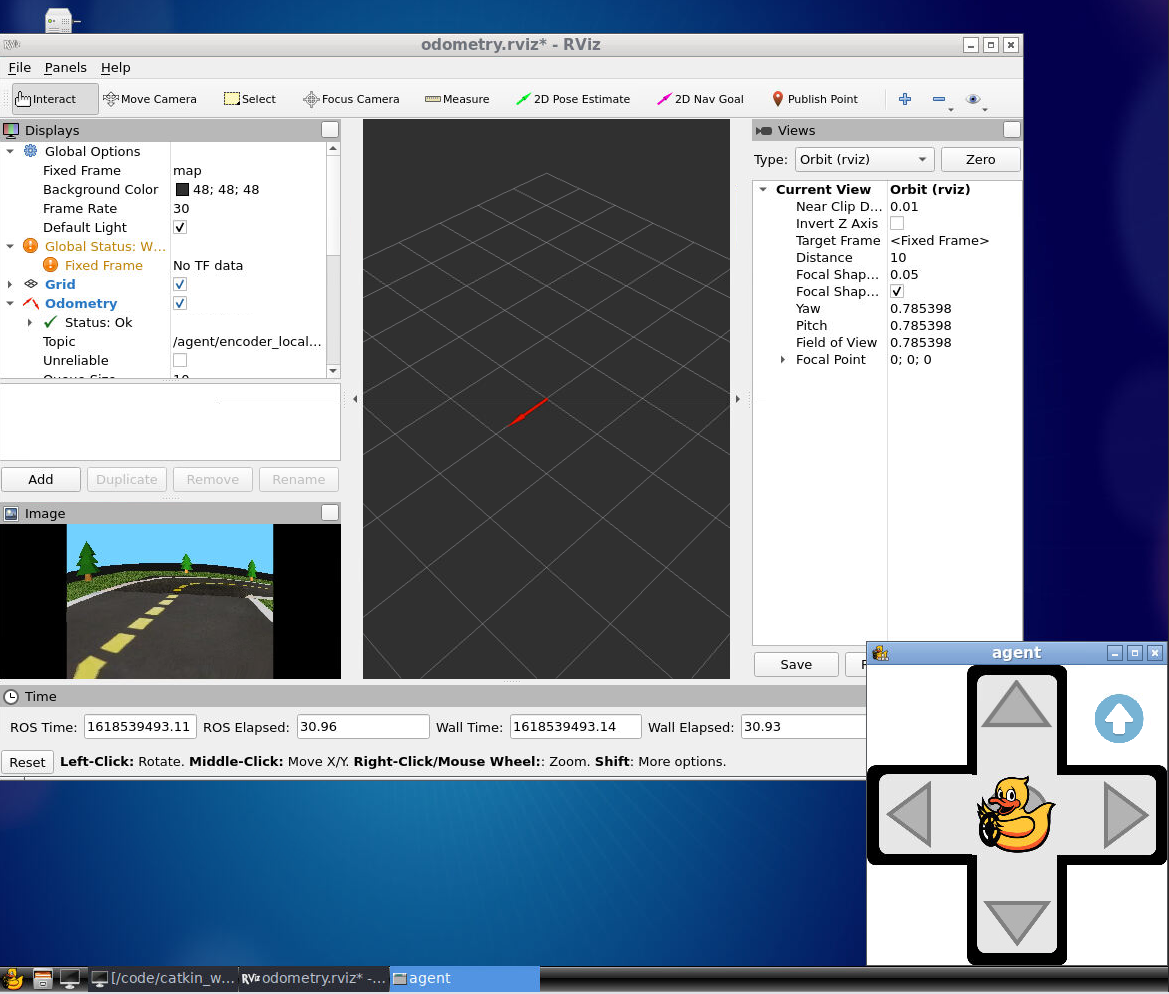</p>  

In the RVIZ window you will see what your robot sees, and a red arrow in the gridmap. That arrow represents the position and orientation of your robot _according to the `poseEsimate` and `DeltaPhi` functions written above_. 

Tips: 

    - You can change the graphical settings of the arrow (bigger, shorter, more or less frequently updated, etc.) through the Odometry > Shape options in the top left quadrant of the RVIZ window;
    
    - You can press `Alt` while clicking and dragging anywhere in the RVIZ terminal to move the window;
    
    - VNC opens with the resolution of your browser window when you launch it. If things look crammed, put your browser in full screen and re-copy and paste the URL. 
    
    - The terminal on your computer will be streaming some debugging data, FYI. 
    
5. Click on the virtual joystick and start driving. You will see the red arrow move too according to the wheel encoder data that the robot is receiving. You can monitor these (and other) messages by following the procedure learned in the [wheel encoders tutorial](../04-Wheel-Encoders-Tutorial/wheel_encoders_tutorial.ipynb). 

6. Drive as you wish (don't crash or you will have to restart!) We suggest doing a nice loop. Get back to the initial position and look at the resulting odometry. Is your robot's _belief_ accurate? Why, or why not? 

7. When you are satisfied with your experience and your odometry, `Ctrl-C` the terminal on your computer to stop VNC, or `Ctrl-C` your open terminal in VNC to go back to the desktop. 

Do you want to modify your odometry functions before proceeding? Change the cells above, `Ctrl-S` to save the page, and re-launch `dts exercises test --sim`. 

<p style="text-align:center;"><img src="../images/odometry/sim-odom-complete.png" width="500" alt="successful-test-odometry"></p> 

If you do not have a robot, you can now proceed to the [PID control activity](../06-PID-Control/PID_controller.ipynb). If you have a robot instead, buckle your Duckies up and continue reading, it's time to have some more fun!

## 🚙 Running the odometry activity on the Duckiebot 

The procedure for running this activity on your Duckiebot is very similar to above, and the same tips apply. 

0. Make sure your Duckiebot is powered on, charged, and connected to the network. Moreover, make sure you have calibrated your robots kinematic parameters. 

1. Computer -> Open terminal

        dts exercises build
        
        dts exercises test -b ROBOTNAME   

2. Open VNC on you browser. 

3. Double-click on the "Odometry" icon on the Desktop 

You will see three things opening: 

- a terminal
- a pre-configured RVIZ window
- a virtual joystick

In the RVIZ window you will see what your robot sees, and a red arrow in the gridmap. That arrow represents the position and orientation of your robot _according to the `poseEsimate` and `DeltaPhi` functions written above_. 
    
4. Click on the virtual joystick and start driving. You will see the red arrow move too according to the wheel encoder data that the robot is receiving. You can monitor these (and other) messages by following the procedure learned in the [wheel encoders tutorial](../04-Wheel-Encoders-Tutorial/wheel_encoders_tutorial.ipynb). 

5. Drive as you wish. We suggest driving in your Duckietown for two reasons: (a) you should have calibrated the gain of your motors so not to slip and (b) you will have a reference of the approximate driven path. Or you can drive around your house; or do both. Whatever you do, get back to the initial position (approximately) and look at the resulting odometry. Is your robot's _belief_ accurate? Why, or why not? 

6. When you are satisfied with your experience and your odometry, `Ctrl-C` the terminal on your computer to stop VNC, or `Ctrl-C` your open terminal in VNC to go back to the desktop. 

Do you want to modify your odometry functions before proceeding? Change the cells above, `Ctrl-S` to save the page, and re-launch `dts exercises test -b ROBOTNAME`. 

<figure>
  <div style="text-align:center;">
<img src="../images/odometry/odometry-real-2.png" width="400" alt="successful-test-odometry-real">
  <figcaption>DB21M Duckiebot odometry.</figcaption>
  </div>
</figure>

## 🚙 Improving on the results

There are many factor that affect the odometry and cause a drift over time. Although that is unavoidable, having an accurate estimate of the odometry parameters of the robot ($R$, $L$) will help. To improve your results above, modify your kinematic calibration parameters and try again. 

We can find $r$ with a simple calibration experiment with our robot:

1. Place a Duckebot on a straight Duckietown road. 
2. Open two terminals and look at the left and wheel encoders messages.
3. Write down the abosolute value of ticks from both wheels.

In [4]:
# Start of the experiment 

ticks_left_start = 3897
ticks_right_start = 3881

4. Push, by hand (don't send commands!) the robot on a straight line for ~ 2m distance. The key idea here is that you are imposing the same travelled distance to each wheel. 
5. Write down the absolute value of ticks from both wheels.

In [5]:
# End of the experiment 

ticks_left_end = 4843
ticks_right_end = 4834

By imposing that the wheels travel the same distance ($d_l = d_r$), and expressing the left and right wheels as $R_l = R(1-r)$, $R_r = R(1+r)$ it is straightforward to find $r$. 

In [6]:
# TODO: test and explain this

Dticks_left = ticks_left_end - ticks_left_start
Dticks_right = ticks_right_end - ticks_right_start

k = Dticks_right / Dticks_left

r = (1-k)/(1+k)

print(r)

-0.0036861506055818716


Best results are obtained by repeating the experiment a few times and averaging the results. Implement the changes in your odometry function and test away!

Before and after accounting for different wheels size:




### 💡 Reflecting on the experience

The first thing you should have noticed is if your odometry made any sense at all. Did your motion reconstruction follow the actual drving? 

Even if your equations were correct, how accurate was the reconstruction? In the short run vs. the long run? Why? 

Try driving several loops (you can set how many arrows will be shown, reduce the number to avoid a big mess). Does it get better or worst? Why? 

Did you notice anything different in the robot movement vs. the model we made? For example? 

On the Duckiebot, how will your odometry change if you tweak you kinematics parameters? Can you get it to do better? 

Congratulations, you just gave your robot the ability to _represent_ itself in the world. It's kind of, nearly, as if, it started thinking (or not?)! You can now proceed to the next activity: designing a [PID controller for heading control](../06-PID-Control/PID_controller.ipynb). 